# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import datetime as dt
from sklearn.model_selection import train_test_split

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Explore data

### porfolio data

In [2]:
print(portfolio)
print("")
print(portfolio.info())
print("")
print(portfolio.describe())

                       channels  difficulty  duration  \
0       [email, mobile, social]          10         7   
1  [web, email, mobile, social]          10         5   
2          [web, email, mobile]           0         4   
3          [web, email, mobile]           5         7   
4                  [web, email]          20        10   
5  [web, email, mobile, social]           7         7   
6  [web, email, mobile, social]          10        10   
7       [email, mobile, social]           0         3   
8  [web, email, mobile, social]           5         5   
9          [web, email, mobile]          10         7   

                                 id     offer_type  reward  
0  ae264e3637204a6fb9bb56bc8210ddfd           bogo      10  
1  4d5c57ea9a6940dd891ad53e9dbe8da0           bogo      10  
2  3f207df678b143eea3cee63160fa8bed  informational       0  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9           bogo       5  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       discount       5  
5  229

In [3]:
# check for duplicates
sum(portfolio.id.duplicated())

0

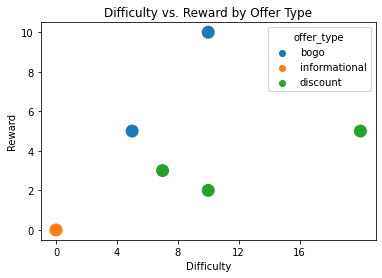

In [4]:
sns.scatterplot(data=portfolio, x="difficulty", y="reward", hue="offer_type", s=200);
plt.xlabel('Difficulty');
plt.ylabel('Reward');
plt.title("Difficulty vs. Reward by Offer Type");
plt.xticks(np.arange(0, 20, 4));

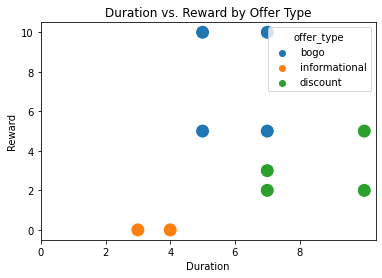

In [5]:
sns.scatterplot(data=portfolio, x="duration", y="reward", hue="offer_type", s=200);
plt.xlabel('Duration');
plt.ylabel('Reward');
plt.title("Duration vs. Reward by Offer Type");
plt.xticks(np.arange(0, 10, 2));

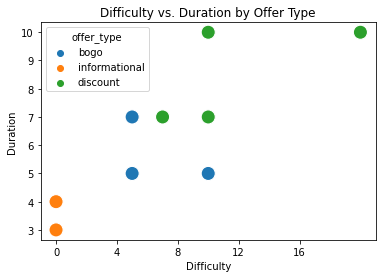

In [6]:
sns.scatterplot(data=portfolio, x="difficulty", y="duration", hue="offer_type", s=200);
plt.xlabel('Difficulty');
plt.ylabel('Duration');
plt.title("Difficulty vs. Duration by Offer Type");
plt.xticks(np.arange(0, 20, 4));

### profile data

In [7]:
print(profile.head())
print("")
print(profile.info())
print("")
print(profile.describe())

   age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB
None

                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.9915

In [8]:
# Do we have any duplicated users?
sum(profile.id.duplicated())

0

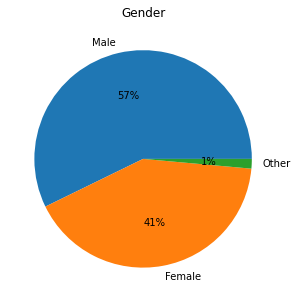

In [9]:
# Gender  
labels = ['Male', 'Female', 'Other']
ax = profile['gender'].value_counts().plot(kind='pie', figsize=(5, 5), autopct='%1.0f%%',labels=labels,title="Gender");
ax.yaxis.set_visible(False)

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


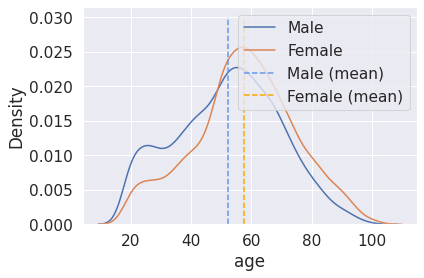

In [101]:
# Gender by age (remove 118 as proxy for no value)
sns.distplot(profile[(profile.gender=='M') & (profile.age < 118)].age,label='Male',hist=False)
sns.distplot(profile[(profile.gender=='F') & (profile.age < 118)].age,label='Female', hist=False)
male_mean = np.mean(profile[(profile.gender=='M') & (profile.age < 118)].age)
female_mean = np.mean(profile[(profile.gender=='F') & (profile.age < 118)].age)
plt.plot([male_mean, male_mean], [0, .03],label = 'Male (mean)',linestyle="dashed",color="cornflowerblue")
plt.plot([female_mean, female_mean], [0, 0.03],label = 'Female (mean)',linestyle="dashed",color="orange")
plt.legend()
plt.show()

In [102]:
print("Male mean:", male_mean)
print("Female mean:", female_mean)

Male mean: 52.11669024045262
Female mean: 57.54495023658019


In [11]:
# Check how many customers we have that did not provide their age (in percentage)
sum(profile.age == 118)/sum(profile.age)

0.0020460305126646936

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


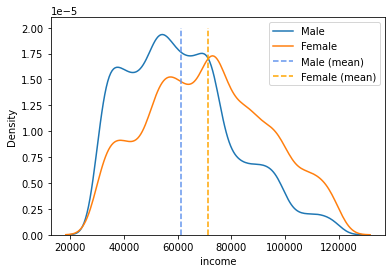

In [12]:
# Income distribution by gender
sns.distplot(profile[profile.gender=='M'].income,label='Male',hist=False)
sns.distplot(profile[profile.gender=='F'].income,label='Female', hist=False)
male_mean = np.mean(profile[profile.gender=='M'].income)
female_mean = np.mean(profile[profile.gender=='F'].income)
plt.plot([male_mean, male_mean], [0, 0.00002],label = 'Male (mean)',linestyle="dashed",color="cornflowerblue")
plt.plot([female_mean, female_mean], [0, 0.00002],label = 'Female (mean)',linestyle="dashed",color="orange")
plt.legend()
plt.show()

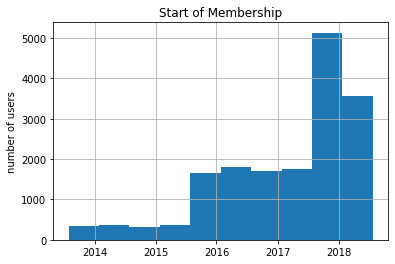

In [13]:
# When did the members sign up
pd.to_datetime(profile.became_member_on.astype(str), format='%Y%m%d').hist();
plt.title('Start of Membership');
plt.ylabel("number of users");

In [14]:
print("first membership: ",min(pd.to_datetime(profile.became_member_on.astype(str), format='%Y%m%d')))
print("most recent membership: ",max(pd.to_datetime(profile.became_member_on.astype(str), format='%Y%m%d')))

first membership:  2013-07-29 00:00:00
most recent membership:  2018-07-26 00:00:00


### transcript data

In [15]:
print(transcript.head())
print("")
print(transcript.info())
print("")
print(transcript.describe())

            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None

           

In [16]:
# check for null or NaN values
print(transcript.isnull().sum())
print("")
print(transcript.isna().sum())

event     0
person    0
time      0
value     0
dtype: int64

event     0
person    0
time      0
value     0
dtype: int64


In [17]:
transcript.groupby(["event"])["person"].count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [18]:
transcript.shape[0]

306534

# Clean data

In [19]:
# First, lets make copies and not change the raw data
portfolio_df = portfolio.copy()
profile_df = profile.copy()
transcript_df = transcript.copy()

In [20]:
# remove fraction of customers that did not provide their age (fraction was << 1%, see above)
profile_df = profile_df[profile_df.age<118]

In [21]:
# convert dates into date object
profile_df.became_member_on = pd.to_datetime(profile_df.became_member_on.astype(str), format='%Y%m%d').dt.date
profile_df.head()

,age,became_member_on,gender,id,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [22]:
today = dt.datetime(2022,12,21)
profile_df["member_since"] = (today - pd.to_datetime(profile_df.became_member_on)).dt.days # in days
profile_df.drop(columns=["became_member_on"], inplace=True)

In [23]:
# change days into hrs, also to be consistent with "time" below
portfolio_df.duration = portfolio_df.duration * 24

In [24]:
# rename cols (to avoid any confusion)
portfolio_df.rename(columns={"id": "id_offer"}, inplace = True)
profile_df.rename(columns={"id": "id_customer"}, inplace = True)

In [25]:
# read values from value col in transcript df
transcript_df = pd.concat([transcript_df, transcript_df['value'].apply(pd.Series)], axis=1)

In [26]:
# check outcome
transcript_df.sample(5)

,event,person,time,value,offer id,amount,offer_id,reward
11540,offer received,408c1015bbf04d6b975f374c00f69dcd,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN
263215,offer completed,a551a070a9484cd69ca431f79b98f056,582,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0
149551,transaction,0561e602225b441aac45ff6e5bb74037,402,{'amount': 4.52},NaN,4.52,NaN,NaN
231386,transaction,72b40f47cf284501b0f32c6ec0bfd069,534,{'amount': 1.99},NaN,1.99,NaN,NaN
197546,transaction,967e2f8cabb948e1944f7472b2ca92f7,486,{'amount': 16.16},NaN,16.16,NaN,NaN


In [27]:
# we got duplicated cols (offer id vs offer_id) -> combine both columns in new column "id_offer"
transcript_df["id_offer"] = np.where(transcript_df['offer_id'].isnull(), transcript_df['offer id'], transcript_df['offer_id'])
transcript_df.drop(columns=['offer_id','offer id',"value"],inplace=True)
transcript_df.sample(10)

,event,person,time,amount,reward,id_offer
305311,transaction,ebc303bcc1b44aa6b4d1762960451468,708,12.52,NaN,NaN
82460,transaction,17056c2cfb384ba1aae130fe0044fe79,204,2.49,NaN,NaN
82684,transaction,70ad38ba603b4703a521c46554fda1c5,204,0.64,NaN,NaN
122348,offer received,a0de41aa3dfe49ca8d6eef995d3eba66,336,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
174277,offer viewed,394775ef5c614facb20af9e4fc9a9f23,420,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
14724,offer viewed,b7aa6f74b09b40d89cfbdbba1350b282,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
97556,transaction,60ce7058fd174a128b48371bd1dbd61b,258,6.38,NaN,NaN
118237,offer received,0975267d50f7470da79d18591352e13d,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
237897,transaction,a245499a51c948829ac0825d9c669ee8,552,0.69,NaN,NaN
91629,transaction,970f224ba9bd40599b8916c132b58b39,234,6.53,NaN,NaN


In [28]:
# replace amount and reward NaN with zero's
transcript_df.amount = transcript_df.amount.fillna(0)
transcript_df.reward = transcript_df.reward.fillna(0)

In [29]:
# Merge all three datasets and start with transcript and portfolio
df =pd.merge(transcript_df, portfolio_df, how = 'left', on = "id_offer")
df.sample(10)

,event,person,time,amount,reward_x,id_offer,channels,difficulty,duration,offer_type,reward_y
282032,transaction,2a793c13ad9d43eb95da32e8b7a5a079,624,17.37,0.0,NaN,NaN,NaN,NaN,NaN,NaN
181151,transaction,d37f9b61415e4a7bb032df9f96abbb6d,438,0.17,0.0,NaN,NaN,NaN,NaN,NaN,NaN
250150,offer received,f694568bf7d94b74b98a4c824b9c4a13,576,0.00,0.0,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,72.0,informational,0.0
247178,offer received,70425153d8ec410d823ee209aa49700b,576,0.00,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,120.0,bogo,10.0
75825,transaction,df6aa41febb14d8d8e05ee665a3fe00f,186,13.94,0.0,NaN,NaN,NaN,NaN,NaN,NaN
74723,offer viewed,27b2dc1b194f4451b0966de7a29c55a9,180,0.00,0.0,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,240.0,discount,2.0
281454,transaction,3d92ee9eb0b444a6bc99e01c46e043ce,618,14.77,0.0,NaN,NaN,NaN,NaN,NaN,NaN
191477,transaction,0375600415e24e0a9fd83ec191d5955d,468,3.10,0.0,NaN,NaN,NaN,NaN,NaN,NaN
96336,transaction,a62b73003f084ae4ae59c4b0e617f647,252,20.97,0.0,NaN,NaN,NaN,NaN,NaN,NaN
202837,offer received,48a6e49849bd4375a4463eda85789a29,504,0.00,0.0,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,72.0,informational,0.0


In [30]:
# combine both reward cols and drop them aftewards
df["reward"] = np.where(df['reward_x'].isnull(), df['reward_y'], df['reward_x'])
df.drop(columns=['reward_x','reward_y'],inplace=True)
df.sample(10)

,event,person,time,amount,id_offer,channels,difficulty,duration,offer_type,reward
215497,offer viewed,5433b75812d94a7faf79c6b81a10c506,504,0.00,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,120.0,bogo,0.0
18266,offer completed,b13775803ef54a42970428c05b9f3dfb,12,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,120.0,bogo,10.0
255297,offer received,8d7f019460c6461e9eb6d2022d8b84ef,576,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,240.0,discount,0.0
286393,offer completed,54f2fd27d5aa4cfd822219e833cc2af3,636,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,120.0,bogo,10.0
41823,offer viewed,16ce6c584b214299b3e8bdfbca8235cb,96,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,240.0,discount,0.0
291993,transaction,329baea6cdfe4b42ac0479f38a0e50ad,654,14.33,NaN,NaN,NaN,NaN,NaN,0.0
61668,offer received,7f57c1760524405f8e23871c1d80694a,168,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,240.0,discount,0.0
197656,transaction,3c5e22dca5164b0ca1203e2ba2a31ca7,486,4.64,NaN,NaN,NaN,NaN,NaN,0.0
171159,offer viewed,8dda575c2a1d44b9ac8e8b07b93d1f8e,414,0.00,ae264e3637204a6fb9bb56bc8210ddfd,"[email, mobile, social]",10.0,168.0,bogo,0.0
133335,transaction,f883a0574d944b0488bca8cc4b22a728,354,24.15,NaN,NaN,NaN,NaN,NaN,0.0


In [31]:
df =pd.merge(df, profile_df, how = 'left', left_on = "person", right_on="id_customer")
df.drop(columns=['person'],inplace=True)
df.sample(10)

,event,time,amount,id_offer,channels,difficulty,duration,offer_type,reward,age,gender,id_customer,income,member_since
283595,transaction,624,15.84,NaN,NaN,NaN,NaN,NaN,0.0,77.0,F,24b7186006df42968b948016dda0030a,57000.0,3355.0
242737,transaction,564,1.11,NaN,NaN,NaN,NaN,NaN,0.0,31.0,M,42f35f86d08c45b39814fb3e4dbe8c07,63000.0,1855.0
13335,transaction,0,2.18,NaN,NaN,NaN,NaN,NaN,0.0,64.0,M,8f808e51d5614c859a4cd1ea857ba917,41000.0,1881.0
226012,offer viewed,522,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,120.0,bogo,0.0,38.0,F,1c02de7f5703489293709fc1a9708197,57000.0,1842.0
12533,offer received,0,0.00,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,72.0,informational,0.0,57.0,F,86d03d35d7e0434b935e7743e83be3a0,53000.0,2186.0
218112,offer viewed,504,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,240.0,discount,0.0,NaN,NaN,NaN,NaN,NaN
299245,transaction,678,4.86,NaN,NaN,NaN,NaN,NaN,0.0,60.0,M,c3d7053eff574ef99a732b5b7a1749ed,44000.0,2150.0
192162,offer viewed,468,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,168.0,bogo,0.0,NaN,NaN,NaN,NaN,NaN
291419,transaction,648,11.05,NaN,NaN,NaN,NaN,NaN,0.0,30.0,F,149712de2ae24c219b992cb3a5f432bc,33000.0,2099.0
230992,transaction,534,13.23,NaN,NaN,NaN,NaN,NaN,0.0,50.0,M,5ec9aeb4a48e4c5abfa6732d73ca3f7b,37000.0,2584.0


In [32]:
sum(df.id_customer.isna())/df.shape[0]

0.11017374907840566

In [33]:
# drop records where we do not have information on customer
df = df[~df.id_customer.isna()]
sum(df.id_customer.isna())/df.shape[0]

0.0

In [34]:
# before sorting, assign each transaction a process number (easier to process below)
# 1) offer received 2) offer viewed 3) transaction 4) offer completed
conditions = [
    (df['event'] == "offer received"),
    (df['event'] == "offer viewed"),
    (df['event'] == "transaction"),
    (df['event'] == "offer completed")
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3, 0]

# create a new column and use np.select to assign values to it using our lists as arguments
df['event_num'] = np.select(conditions, values)

In [35]:
# get order in offer processes
df = df.sort_values(['id_customer','time','event_num'])

In [36]:
df.head(20)

,event,time,amount,id_offer,channels,difficulty,duration,offer_type,reward,age,gender,id_customer,income,member_since,event_num
55972,offer received,168,0.00,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,72.0,informational,0.0,33.0,M,0009655768c64bdeb2e877511632db8f,72000.0,2070.0,1
77705,offer viewed,192,0.00,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,72.0,informational,0.0,33.0,M,0009655768c64bdeb2e877511632db8f,72000.0,2070.0,2
89291,transaction,228,22.16,NaN,NaN,NaN,NaN,NaN,0.0,33.0,M,0009655768c64bdeb2e877511632db8f,72000.0,2070.0,3
113605,offer received,336,0.00,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,96.0,informational,0.0,33.0,M,0009655768c64bdeb2e877511632db8f,72000.0,2070.0,1
139992,offer viewed,372,0.00,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,96.0,informational,0.0,33.0,M,0009655768c64bdeb2e877511632db8f,72000.0,2070.0,2
153401,offer received,408,0.00,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,120.0,bogo,0.0,33.0,M,0009655768c64bdeb2e877511632db8f,72000.0,2070.0,1
168413,offer completed,414,0.00,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,120.0,bogo,5.0,33.0,M,0009655768c64bdeb2e877511632db8f,72000.0,2070.0,0
168412,transaction,414,8.57,NaN,NaN,NaN,NaN,NaN,0.0,33.0,M,0009655768c64bdeb2e877511632db8f,72000.0,2070.0,3
187554,offer viewed,456,0.00,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,120.0,bogo,0.0,33.0,M,0009655768c64bdeb2e877511632db8f,72000.0,2070.0,2
204340,offer received,504,0.00,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,240.0,discount,0.0,33.0,M,0009655768c64bdeb2e877511632db8f,72000.0,2070.0,1


In [37]:
# I apply the following logic to label effective offers
# i) there needs to be a transaction
# ii) transaction needs to happen in the given duration of the offer
# iii) it needs to include the following events (in correct order): offer received, offer viewed, transaction

# first drop duplicates, if any
df = df.drop_duplicates(subset=df.columns.difference(['channels'])) # ignore column channels due to not matching data type

# we do not care for the event 'offer completed'
df = df[df.event_num > 0]

# compute deadline for offer starting with time when offer received
df["offer_threshold"]=np.where(df['event']=="offer received", df['time']+df['duration'], float('nan'))
# same deadline for the next event stept
df.offer_threshold = df.offer_threshold.ffill()

# fill NaN with data from events before of that customer
df.update(df.groupby(["id_customer"]).ffill())

# label offers as effective
# only offers that go through the regular order of subsequent steps (event_num in ascending order) and which happen before end of deadline
df["effective"]=np.where((df['event_num'].shift(1)-df['event_num'] >= 0)| (abs(df['event_num'].shift(1)-df['event_num']) > 1)| (df.time > df.offer_threshold), 0, 1)

# Since "offer received" is the first step, my previous step would always label it as ineffective (put back to effective by default)
df["effective"]=np.where(df['event']=="offer received", 1, df.effective)
    

In [38]:
for _, sub in df.groupby(['id_offer','id_customer']):
    if (sub['event_num'].sum() < 6): # the customer / offer combination needs to at least include offer received, offer viewed and transaction
        df.update(sub['effective'] * 0)

In [39]:
for _, sub in df.groupby(['id_offer','id_customer']):
    if (sub['effective'].sum() < 3): 
        df.update(sub['effective'] * 0)

In [41]:
df_effective = df[df.event_num == 1].copy() # for each process, only consider first step; remaining events for the offer/customer combination only include redundant information
df_effective.drop(columns=["time","id_offer", "id_customer", "offer_threshold", "event_num","duration", "event", "amount", "difficulty"], inplace = True)

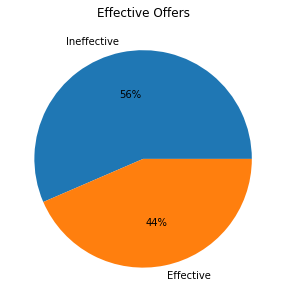

In [42]:
labels = ['Ineffective', 'Effective']
ax = df_effective['effective'].value_counts().plot(kind='pie', figsize=(5, 5), autopct='%1.0f%%',labels=labels,title="Effective Offers");
ax.yaxis.set_visible(False)

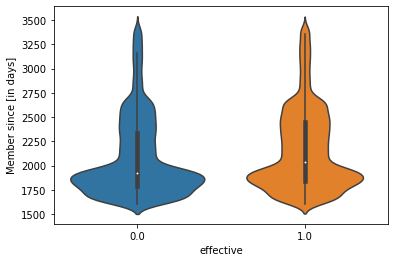

In [43]:
sns.violinplot(data=df_effective, x="effective", y="member_since");
plt.ylabel('Member since [in days]');

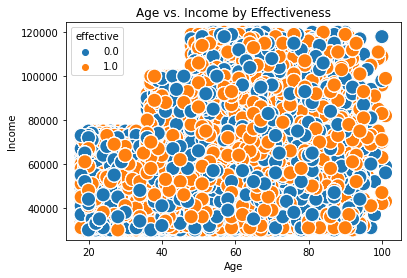

In [44]:
sns.scatterplot(data=df_effective, x="age", y="income", hue="effective", s=200);
plt.xlabel('Age');
plt.ylabel('Income');
plt.title("Age vs. Income by Effectiveness");

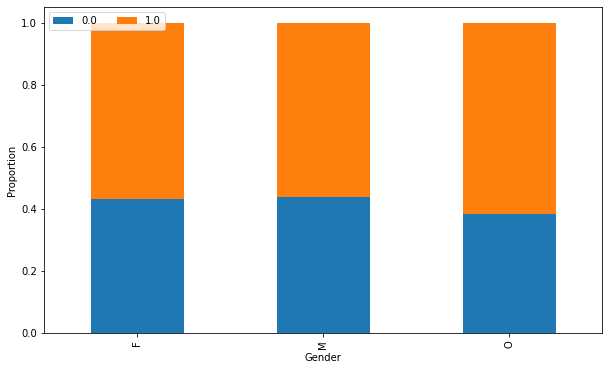

In [45]:
cross_tab_prop = pd.crosstab(index=df_effective['gender'],
                             columns=df_effective['effective'],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    #colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Gender")
plt.ylabel("Proportion")
plt.show()

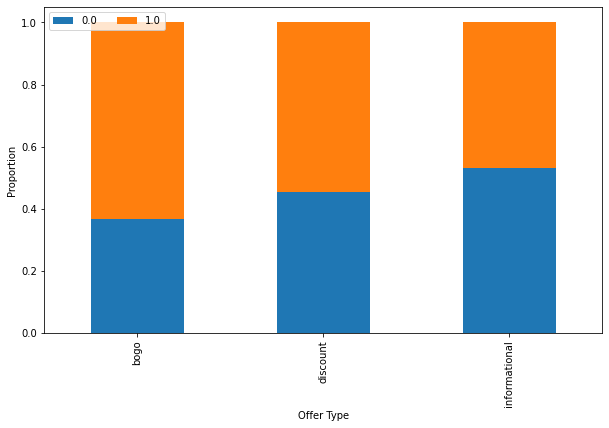

In [46]:
cross_tab_prop = pd.crosstab(index=df_effective['offer_type'],
                             columns=df_effective['effective'],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    #colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Offer Type")
plt.ylabel("Proportion")
plt.show()

In [47]:
df_effective.groupby(["effective"]).mean()

,reward,age,income,member_since
effective,,,,
0.0,0.0,54.515776,65602.239348,2085.026333
1.0,0.0,54.256389,65193.962304,2166.240336


In [48]:
# create dummy variables for gender (easier to process afterwards in our model)
df_effective = df_effective.join(pd.DataFrame(
    pd.get_dummies(df_effective.gender.apply(pd.Series).stack()).sum(level=0), 
    index=df_effective.index, 
    columns=['F', 'M', 'O']
))

# drop channels col (redundant information otherwise)
df_effective.drop(columns=['gender'],inplace=True)

In [49]:
# create dummy variables for channel (easier to process afterwards in our model)
df_effective = df_effective.join(pd.DataFrame(
    pd.get_dummies(df_effective.channels.apply(pd.Series).stack()).sum(level=0), 
    index=df_effective.index, 
    columns=['email', 'mobile', 'social', 'web']
))

# drop channels col (redundant information otherwise)
df_effective.drop(columns=['channels'],inplace=True)

In [50]:
# create dummy for offer_type
df_effective = df_effective.join(pd.DataFrame(
    pd.get_dummies(df_effective.offer_type.apply(pd.Series).stack()).sum(level=0), 
    index=df_effective.index, 
    columns=['informational', 'bogo', 'discount']
))

# drop channels col (redundant information otherwise)
df_effective.drop(columns=['offer_type'],inplace=True)

In [51]:
df_effective.sample(3)

,reward,age,income,member_since,effective,F,M,O,email,mobile,social,web,informational,bogo,discount
11905,0.0,53.0,59000.0,1794.0,1.0,0,1,0,1,1,1,1,0,0,1
817,0.0,57.0,83000.0,2382.0,1.0,0,1,0,1,1,1,1,0,0,1
202089,0.0,59.0,90000.0,1953.0,0.0,1,0,0,1,1,1,0,0,1,0


# Build model

In [70]:
#split the dataset into test and train sets.
Y = df_effective.effective
X = df_effective.drop(columns=["effective"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [72]:
# Import the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [73]:
# Instantiate a RandomForestClassifier with
# 200 weak learners (n_estimators) 
rf = RandomForestClassifier(n_estimators = 200)

In [74]:
# Fit the RandomForestClassifier model
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [75]:
# Call to test the model on the test data
predictions = rf.predict(X_test)

In [76]:
print('Random Forest scores')

print('Accuracy score: ', format(accuracy_score(y_test, predictions)))
print('Precision score: ', format(precision_score(y_test, predictions)))
print('Recall score: ', format(recall_score(y_test, predictions)))
print('F1 score: ', format(f1_score(y_test, predictions)))

Random Forest scores
Accuracy score:  0.7250764372713148
Precision score:  0.7336471352053238
Recall score:  0.804055856977675
F1 score:  0.7672395501803522


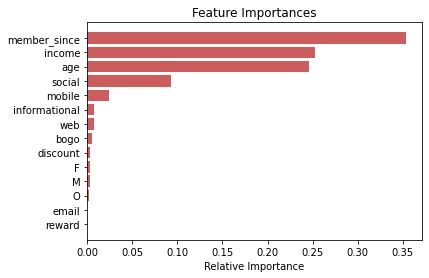

In [77]:
# used the following source to plot the feature importance: https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='indianred', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [83]:
conf_mat = confusion_matrix(y_test, predictions)
print(conf_mat)

[[5426 3282]
 [2203 9040]]


In [84]:
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
print(conf_mat)

[[0.62310519 0.37689481]
 [0.19594414 0.80405586]]


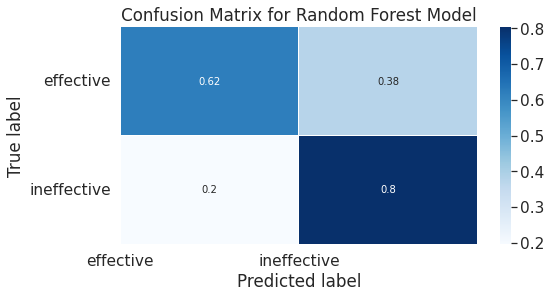

In [99]:
# Build the plot; Source: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
plt.figure(figsize=(8,4))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, annot_kws={'size':10},
            cmap="Blues", linewidths=0.2)

# Add labels to the plot
class_names = ['effective', 'ineffective']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

#### Tuning parameters

##### n_estimators

In [59]:
scores =[]
for k in range(10, 300, 10):
    rf_k = RandomForestClassifier(n_estimators=k)
    rf_k.fit(X_train, y_train)
    predictions = rf_k.predict(X_test)
    scores.append(accuracy_score(y_test, predictions))

In [60]:
max_score = max(scores) # highest accuracy
max_score_index = scores.index(max_score) # index

In [61]:
print(f"Accuracy Score: {max_score} with n_estimators: {(max_score_index+1)*10}") # also correct that we start from 10 and have a step size of 10

Accuracy Score: 0.7271815949075234 with n_estimators: 190


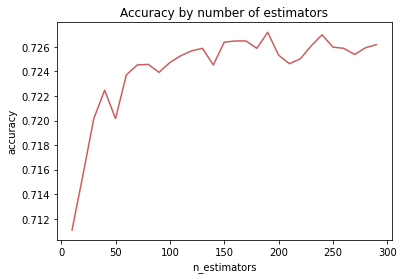

In [62]:
plt.title("Accuracy by number of estimators")
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.plot(range(10, 300,10), scores, color ="indianred")
plt.show()

##### Disable bootstrap

In [63]:
rf_boot = RandomForestClassifier(n_estimators = 200, bootstrap = False) # disable bootstrapping
rf_boot.fit(X_train, y_train)
predictions = rf_boot.predict(X_test)
print('Accuracy score: ', format(accuracy_score(y_test, predictions)))

Accuracy score:  0.7094381234023357


#### Adding features

In [64]:
df_effective_new = df[df.event_num == 1].copy() # for each process, only consider first step; remaining events for the offer/customer combination only include redundant information
df_effective_new.drop(columns=["id_offer", "id_customer", "offer_threshold", "event_num","duration", "event"], inplace = True)

In [65]:
# create dummy variables for gender (easier to process afterwards in our model)
df_effective_new = df_effective_new.join(pd.DataFrame(
    pd.get_dummies(df_effective_new.gender.apply(pd.Series).stack()).sum(level=0), 
    index=df_effective_new.index, 
    columns=['F', 'M', 'O']
))

# drop channels col (redundant information otherwise)
df_effective_new.drop(columns=['gender'],inplace=True)

# create dummy variables for channel (easier to process afterwards in our model)
df_effective_new = df_effective_new.join(pd.DataFrame(
    pd.get_dummies(df_effective_new.channels.apply(pd.Series).stack()).sum(level=0), 
    index=df_effective_new.index, 
    columns=['email', 'mobile', 'social', 'web']
))

# drop channels col (redundant information otherwise)
df_effective_new.drop(columns=['channels'],inplace=True)

# create dummy for offer_type
df_effective_new = df_effective_new.join(pd.DataFrame(
    pd.get_dummies(df_effective_new.offer_type.apply(pd.Series).stack()).sum(level=0), 
    index=df_effective_new.index, 
    columns=['informational', 'bogo', 'discount']
))

# drop channels col (redundant information otherwise)
df_effective_new.drop(columns=['offer_type'],inplace=True)

In [66]:
#split the dataset into test and train sets.
Y_new = df_effective_new.effective
X_new = df_effective_new.drop(columns=["effective"])
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, Y_new, test_size=0.3, random_state=1)

In [67]:
rf_new = RandomForestClassifier(n_estimators = 200)
rf_new.fit(X_train_new, y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [68]:
predictions = rf_new.predict(X_test_new)

In [69]:
print('Accuracy score: ', format(accuracy_score(y_test_new, predictions)))

Accuracy score:  0.681870582928174
